In [ ]:
pip install yfinance scikit-learn matplotlib pandas numpy tensorflow

In [1]:
import yfinance as yf
import pandas as pd

In [5]:
# Download historical stock data (for example, AAPL)
stock_data = yf.download('AAPL', start='2010-01-01', end='2023-01-01')
stock_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.454505,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.465664,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.362820,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.351056,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.393280,447610800
...,...,...,...,...,...,...
2022-12-23,130.919998,132.419998,129.639999,131.860001,130.631378,63814900
2022-12-27,131.380005,131.410004,128.720001,130.029999,128.818405,69007800
2022-12-28,129.669998,131.029999,125.870003,126.040001,124.865585,85438400


In [7]:
# Feature Engineering: Moving Averages
stock_data['MA50'] = stock_data['Close'].rolling(window=50).mean()
stock_data['MA200'] = stock_data['Close'].rolling(window=200).mean()

In [9]:
# Relative Strength Index (RSI)
delta = stock_data['Close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
stock_data['RSI'] = 100 - (100 / (1 + rs))

In [11]:
# Bollinger Bands
stock_data['BB_upper'] = stock_data['Close'].rolling(window=20).mean() + (stock_data['Close'].rolling(window=20).std() * 2)
stock_data['BB_lower'] = stock_data['Close'].rolling(window=20).mean() - (stock_data['Close'].rolling(window=20).std() * 2)

In [13]:
# Drop NaN values
stock_data = stock_data.dropna()

In [15]:
# Display final feature set
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume,MA50,MA200,RSI,BB_upper,BB_lower
Date,,,,,,,,,,,
2010-10-18,11.373929,11.392857,11.224643,11.357143,9.590830,1093010800,9.659357,8.767198,82.037080,11.170869,9.734739
2010-10-19,10.835714,11.206071,10.715000,11.053214,9.334167,1232784000,9.693457,8.784248,69.540640,11.247944,9.749521
2010-10-20,11.035714,11.223214,10.959643,11.090357,9.365530,721624400,9.729971,8.801418,74.787086,11.325330,9.753492
2010-10-21,11.155714,11.240714,10.957143,11.054286,9.335067,551460000,9.772350,8.819016,75.092951,11.387068,9.765325
2010-10-22,11.038214,11.072857,10.939286,10.981071,9.273245,372778000,9.812121,8.836318,77.737135,11.430919,9.775581


In [17]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [19]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data[['Close', 'MA50', 'MA200', 'RSI', 'BB_upper', 'BB_lower']])

In [21]:
# Create sequences of 60 days of past data for each prediction
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i, 0])  # We predict the 'Close' price
    return np.array(X), np.array(y)

In [23]:
SEQ_LEN = 60  # 60 days look-back
X, y = create_sequences(scaled_data, SEQ_LEN)

In [25]:
# Split the data into training and testing sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [35]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.models import Sequential

In [39]:
# Build the LSTM model
model = Sequential()

In [41]:
# Define the input shape using the Input layer
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

In [43]:
# LSTM layers
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))  # Dropout to prevent overfitting
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

In [45]:
# Dense layers
model.add(Dense(units=25))
model.add(Dense(units=1))  # Output layer for stock price prediction

In [47]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [49]:
# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=50)

Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0059
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 7.0555e-04
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 5.3726e-04
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 3.4832e-04
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 2.6628e-04
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 2.8072e-04
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 2.3591e-04
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 2.5792e-04
Epoch 9/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 2.3387e-04
Epoch 10/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 2.8274e-04
Epoch 11/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 2.3395e-04
Epoch 12/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 1.9582e-04
Epoch 13/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 2.0665e-04
Epoch 14/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 2.1673e-04
Epoch 15/50
76/76 ━

In [51]:
# Get the predicted stock prices
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], scaled_data.shape[1] - 1))), axis=1))[:, 0]

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


In [53]:
# Compare with the actual stock prices
y_test = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], scaled_data.shape[1] - 1))), axis=1))[:, 0]

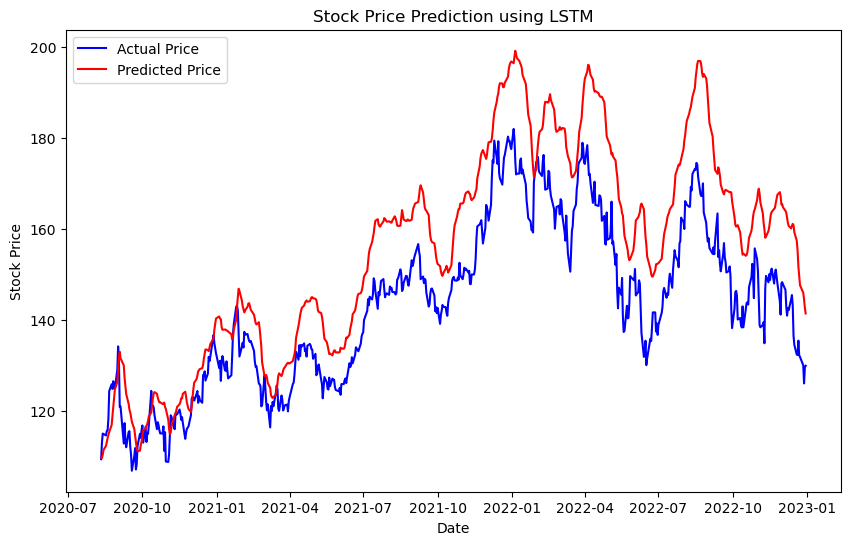

In [55]:
# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(stock_data.index[-len(y_test):], y_test, label='Actual Price', color='b')
plt.plot(stock_data.index[-len(y_test):], predictions, label='Predicted Price', color='r')
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [73]:
future_predictions = []
current_input = X_test[-1]  # Start with the last known input from the test set

for _ in range(30):  # Predict the next 30 days
    next_pred = model.predict(np.expand_dims(current_input, axis=0))
    
    # Append only the predicted 'Close' price to the future predictions
    future_predictions.append(next_pred[0])
    
    # Update the input by creating a new feature array, using the predicted value for the 'Close' price
    # Since 'next_pred' is a single value (Close price), we need to construct the full input
    new_input = np.append(current_input[1:], np.zeros((1, current_input.shape[1])), axis=0)  # Shift window
    new_input[-1, 0] = next_pred  # Update 'Close' price (first feature) with predicted value
    
    current_input = new_input

# Scale back the predictions to original values
future_predictions = scaler.inverse_transform(np.concatenate((future_predictions, np.zeros((len(future_predictions), scaled_data.shape[1] - 1))), axis=1))[:, 0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


C:\Users\rakes\AppData\Local\Temp\ipykernel_13032\1570190998.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_input[-1, 0] = next_pred  # Update 'Close' price (first feature) with predicted value


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━

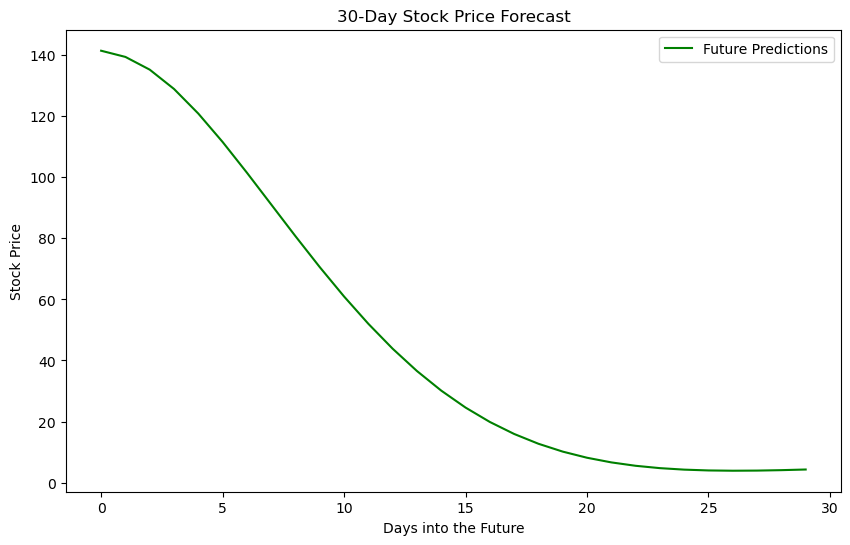

In [75]:
# Plot the future predictions
plt.figure(figsize=(10, 6))
plt.plot(range(len(future_predictions)), future_predictions, label='Future Predictions', color='g')
plt.title('30-Day Stock Price Forecast')
plt.xlabel('Days into the Future')
plt.ylabel('Stock Price')
plt.legend()
plt.show()